In [1]:
import torch
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
X, y = make_blobs(n_samples=3000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5,  random_state=RANDOM_SEED)
X.shape, y.shape

((3000, 2), (3000,))

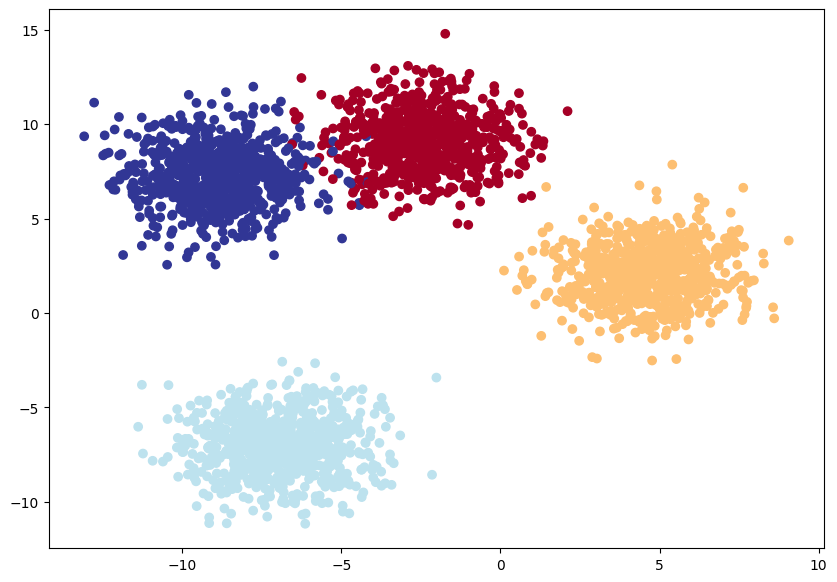

In [3]:
plt.figure(figsize = (10,7))
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdYlBu')

In [4]:
X,y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


In [5]:
class MultiClassClassifier(nn.Module):
  def __init__(self, input_features, output_features, hidden_units =10):
    super().__init__()
    # Assign the nn.Sequential object to self.self_linear_layer_stack
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [6]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
print(f'Using {device} device')

Using cpu device


In [7]:
model_1 = MultiClassClassifier(input_features=NUM_FEATURES, output_features=NUM_CLASSES)
model_1.to(device)

MultiClassClassifier(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

In [9]:
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_test.to(device))

y_logits[:10]

tensor([[-0.2573,  0.0456,  0.1361, -0.0708],
        [-1.8943, -2.3107, -0.9176,  1.2900],
        [-2.2488, -2.8152, -1.1803,  1.5820],
        [-0.2045, -0.2620,  0.0082, -0.2948],
        [-1.8508, -2.1785, -0.7355,  1.4686],
        [-0.1987, -0.2544, -0.0102, -0.2959],
        [ 0.2266,  0.4508,  0.2577, -0.1810],
        [-1.9942, -2.6139, -1.1024,  1.2631],
        [-2.5895, -3.1204, -1.1642,  2.3404],
        [-1.5016, -1.9171, -0.7404,  0.8545]])

In [10]:
y_pred_probs = torch.argmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([2, 3, 3, 2, 3, 2, 1, 3, 3, 3])

In [11]:
from tqdm import tqdm
epochs = 3000
model_1.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
trainLossList = []
testLossList = []
for epoch in range(epochs):
    #training
    model_1.train()

    #forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    #compute loss
    loss = loss_fn(y_logits, y_train.type(torch.long))

    #zero grad optimizer
    optimizer.zero_grad()

    #back propagate
    loss.backward()

    #step the optimizer
    optimizer.step()

    #testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss  = loss_fn(test_logits, test_pred)

    if(epoch%100==0):
        print(f"epoch:{epoch}|train loss:{loss:.5f}|test loss:{test_loss:.5f}")

    trainLossList.append(loss.cpu().detach().numpy())
    testLossList.append(test_loss.cpu().detach().numpy())

epoch:0|train loss:1.55108|test loss:1.06000
epoch:100|train loss:0.02902|test loss:0.02073
epoch:200|train loss:0.02251|test loss:0.01334
epoch:300|train loss:0.02061|test loss:0.01098
epoch:400|train loss:0.01968|test loss:0.00984
epoch:500|train loss:0.01911|test loss:0.00918
epoch:600|train loss:0.01869|test loss:0.00878
epoch:700|train loss:0.01836|test loss:0.00853
epoch:800|train loss:0.01809|test loss:0.00836
epoch:900|train loss:0.01785|test loss:0.00825
epoch:1000|train loss:0.01764|test loss:0.00819
epoch:1100|train loss:0.01746|test loss:0.00816
epoch:1200|train loss:0.01728|test loss:0.00815
epoch:1300|train loss:0.01712|test loss:0.00815
epoch:1400|train loss:0.01698|test loss:0.00817
epoch:1500|train loss:0.01684|test loss:0.00820
epoch:1600|train loss:0.01671|test loss:0.00824
epoch:1700|train loss:0.01658|test loss:0.00828
epoch:1800|train loss:0.01647|test loss:0.00833
epoch:1900|train loss:0.01636|test loss:0.00839
epoch:2000|train loss:0.01625|test loss:0.00845
epoc

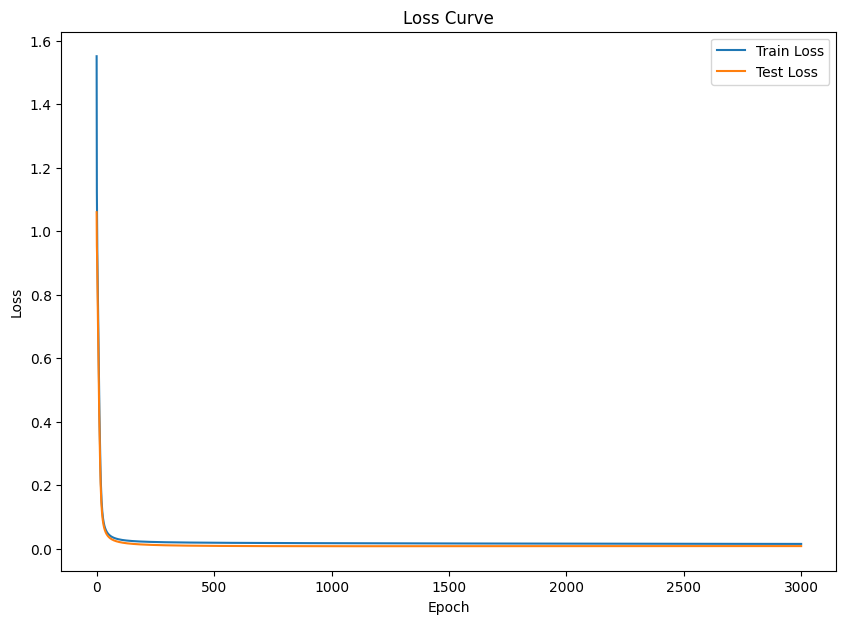

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(trainLossList, label="Train Loss")
plt.plot(testLossList, label="Test Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

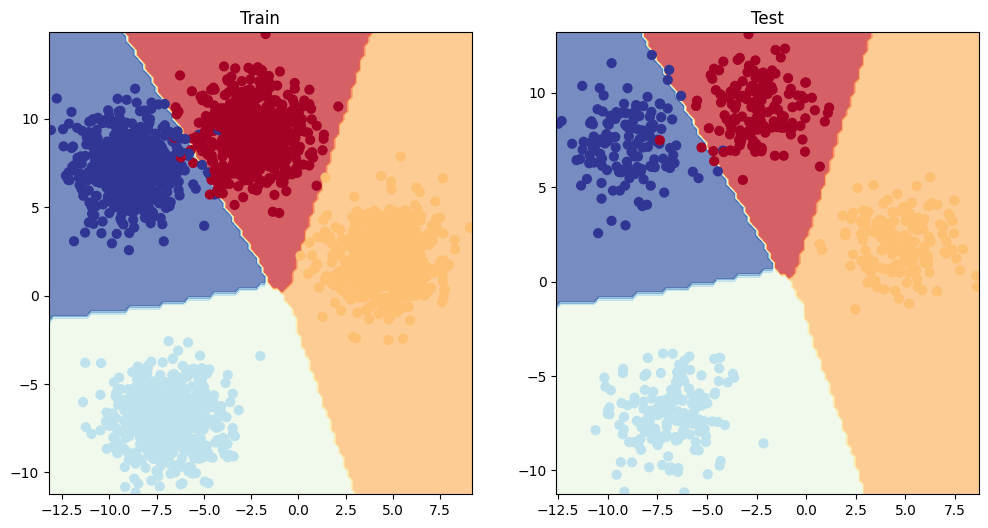

In [17]:

from helper_functions import plot_decision_boundary

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

plt.show()